# Queries with and without Azure OpenAI

So far, you have your Search Engine loaded **from two different data sources in two diferent text-based indexes**, on this notebook we are going to try some example queries and then use Azure OpenAI service to see if we can get even better results.

The idea is that a user can ask a question about Computer Science (first datasource/index) or about Covid (second datasource/index), and the engine will respond accordingly.
This **Multi-Index** demo, mimics the scenario where a company loads multiple type of documents of different types and about completly different topics and the search engine must respond with the most relevant results.

## Set up variables

In [1]:
import os
import urllib
import requests
import random
import json
from collections import OrderedDict
from IPython.display import display, HTML, Markdown
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.llms import AzureOpenAI
from langchain.chat_models import AzureChatOpenAI
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from langchain.chains.question_answering import load_qa_chain
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.embeddings import OpenAIEmbeddings

from common.prompts import COMBINE_QUESTION_PROMPT, COMBINE_PROMPT, COMBINE_PROMPT_TEMPLATE
from common.utils import (
    get_search_results,
    model_tokens_limit,
    num_tokens_from_docs,
    num_tokens_from_string
)

from dotenv import load_dotenv
load_dotenv("credentials_my.env")

print(f'Open AI endpoint: {os.environ["AZURE_OPENAI_ENDPOINT"]}\nDeployment: {os.environ["COMPLETION35_DEPLOYMENT"]}')

Open AI endpoint: https://mmopenai04.openai.azure.com/
Deployment: gpt-35-turbo


In [2]:
# Setup the Payloads header
headers = {'Content-Type': 'application/json','api-key': os.environ['AZURE_SEARCH_KEY']}
params  = {'api-version': os.environ['AZURE_SEARCH_API_VERSION']}

## Multi-Index Search queries

In [3]:
# Text-based Indexes that we are going to query (from Notebook 01 and 02)
index1_name = "cogsrch-index-files"
index2_name = "cogsrch-index-csv"
indexes = [index1_name, index2_name]

Try questions that you think might be answered or addressed in computer science papers in 2020-2021 or that can be addressed by medical publications about COVID in 2020-2021. Try comparing the results with the open version of ChatGPT.<br>
The idea is that the answers using Azure OpenAI only looks at the information contained on these publications.

**Example Questions you can ask**:
- What is CLP?
- How Markov chains work?
- What are some examples of reinforcement learning?
- What are the main risk factors for Covid-19?
- What medicine reduces inflamation in the lungs?
- Why Covid doesn't affect kids that much compared to adults?
- Does chloroquine really works against covid?
- Who won the 1994 soccer world cup? # This question should yield no answer if the system is correctly grounded

In [4]:
QUESTION = "What is CLP?"

### Search on both indexes individually and aggragate results

#### **Note**: 
In order to standarize the indexes, **there must be 8 mandatory fields present on each text-based index**: `id, title, content, chunks, language, name, location, vectorized`. This is so that each document can be treated the same along the code. Also, **all indexes must have a semantic configuration**.

In [5]:
agg_search_results = dict()

for index in indexes:
    search_payload = {
        "search": QUESTION,
        "select": "id, title, chunks, name, location",
        "queryType": "semantic",
        "semanticConfiguration": "my-semantic-config",
        "count": "true",
        "speller": "lexicon",
        "queryLanguage": "en-us",
        "captions": "extractive",
        "answers": "extractive|count-2",
        "top": "4"
    }

    r = requests.post(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + index + "/docs/search",
                     data=json.dumps(search_payload), headers=headers, params=params)
    
    search_results = r.json()
    agg_search_results[index]=search_results
    print(f"Index: {index}\t" + 
          f"Results found: {search_results['@odata.count']}, " +
          f"Results returned: {len(search_results['value'])}, " +
          f"Semantic answers: {len(search_results['@search.answers'])}")

Index: cogsrch-index-files	Results found: 36, Results returned: 4, Semantic answers: 2
Index: cogsrch-index-csv	Results found: 77, Results returned: 4, Semantic answers: 2


### Display the top results (from both searches) based on the score

In [6]:
# First, we print the SEMANTIC answers...
display(HTML('<h4><em>SEMANTIC</em> answers</h4>'))

for index,search_results in agg_search_results.items():
    for result in search_results['@search.answers']:
        if result['score'] > 0.5: # Show answers that are at least 50% of the max possible score=1
            display(HTML(f"<h5>Answer - score: {str(round(result['score'],2))} ({index})</h5>"))
            display(HTML(result['text']))

# here we simply prepare the dictionary and ordered dictionary for hosting the normal results included in the "value" branch
content = dict()
ordered_content = OrderedDict()

for index, search_results in agg_search_results.items():
    for result in search_results['value']:
        if result['@search.rerankerScore'] > 1:# Show answers that are at least 25% of the max possible score=4
            content[result['id']]={
                "title": result['title'],
                "chunks": result['chunks'],
                "name": result['name'],
                "location": result['location'],
                "caption": result['@search.captions'][0]['text'],
                "score": result['@search.rerankerScore'],
                "index": index
            }
            
#... FINALLY, we print the DEFAULT answers
print("\n")
display(HTML('<h4><em>DEFAULT</em> answers</h4>'))
#After results have been filtered we will Sort and add them as an Ordered list\n",
for id in sorted(content, key= lambda x: content[x]["score"], reverse=True):
    ordered_content[id] = content[id]
    url = str(ordered_content[id]['location']) + os.environ['BLOB_SAS_TOKEN']
    title = str(ordered_content[id]['title']) if (ordered_content[id]['title']) else ordered_content[id]['name']
    score = str(round(ordered_content[id]['score'],2))
    display(HTML(f'<h5><a href="{url}"> {title} </a> - score: {score} ({ordered_content[id]["index"]})</h5>'))
    #display(HTML('<h5><a href="'+ url + '">' + title + '</a> - score: '+ score + '</h5>'))
    display(HTML(ordered_content[id]['caption']))

## Comments on Query results

As seen above the semantic search feature of Azure Cognitive Search service is good. It gives us some answers and also the top results with the corresponding file and the paragraph where the answers is possible located.

Let's see if we can make this better with Azure OpenAI

# Using Azure OpenAI

To use OpenAI to get a better answer to our question, the thought process is simple: let's **give the answer and the content of the documents from the search result to the GPT model as context and let it provide a better response**.

Now, before we do this, we need to understand a few things first:

1) Chainning and Prompt Engineering
2) Embeddings

We will use a library call **LangChain** that wraps a lot of boiler plate code.
Langchain is one library that does a lot of the prompt engineering for us under the hood, for more information see [here](https://python.langchain.com/en/latest/index.html)

In [7]:
# Set the ENV variables that Langchain needs to connect to Azure OpenAI
os.environ["OPENAI_API_BASE"]    = os.environ["AZURE_OPENAI_ENDPOINT"]
os.environ["OPENAI_API_KEY"]     = os.environ["AZURE_OPENAI_API_KEY"]
os.environ["OPENAI_API_VERSION"] = os.environ["AZURE_OPENAI_API_VERSION"]
os.environ["OPENAI_API_TYPE"]    = os.environ["OPENAI_API_TYPE"]

**Important Note**: Starting now, we will utilize OpenAI models. Please ensure that you have deployed the following models within the Azure OpenAI portal using these precise deployment names:

- text-embedding-ada-002
- gpt-35-turbo
- gpt-35-turbo-16k
- gpt-4
- gpt-4-32k

Should you have deployed the models under different names, the code provided below will not function as expected. To resolve this, you would need to modify the variable names throughout all the notebooks.

## A gentle intro to chaining LLMs and prompt engineering

Chains are what you get by connecting one or more large language models (LLMs) in a logical way. (Chains can be built of entities other than LLMs but for now, let’s stick with this definition for simplicity).

Azure OpenAI is a type of LLM (provider) that you can use but there are others like Cohere, Huggingface, etc.

Chains can be simple (i.e. Generic) or specialized (i.e. Utility).

* Generic — A single LLM is the simplest chain. It takes an input prompt and the name of the LLM and then uses the LLM for text generation (i.e. output for the prompt).

Here’s an example:

In [8]:
MODEL = os.environ["COMPLETION35_DEPLOYMENT"]  # options: gpt-35-turbo, gpt-35-turbo-16k, gpt-4, gpt-4-32k
COMPLETION_TOKENS = 1000
llm = AzureChatOpenAI(deployment_name=MODEL, temperature=0, max_tokens=COMPLETION_TOKENS)

In [9]:
# Now we create a simple prompt template
prompt = PromptTemplate(
    input_variables=["question", "language"],
    template='Answer the following question: "{question}". Give your response in {language}',
)

print(prompt.format(question=QUESTION, language="French"))

Answer the following question: "What is CLP?". Give your response in French


In [10]:
# And finally we create our first generic chain
chain_chat = LLMChain(llm=llm, prompt=prompt)
chain_chat({"question": QUESTION, "language": "German"})

{'question': 'What is CLP?',
 'language': 'German',
 'text': 'CLP steht für "Classification, Labelling and Packaging" und ist eine Verordnung der Europäischen Union zur Einstufung, Kennzeichnung und Verpackung von chemischen Stoffen und Gemischen. Diese Verordnung legt ein einheitliches System zur Gefahrenkennzeichnung von Chemikalien fest, um die Sicherheit von Mensch und Umwelt zu gewährleisten.'}

**Note**: this is the first time you use OpenAI in this Accelerator, so if you get a Resource not found error, is most likely because the name of your OpenAI model deployment is different than the variable MODEL set above.

Great!!, now you know how to create a simple prompt and use a chain in order to answer a general question using ChatGPT knowledge!. 

It is important to note that we rarely use generic chains as standalone chains. More often they are used as building blocks for Utility chains (as we will see next). Also important to notice is that we are NOT using our documents or the result of the Azure Search yet, just the knowledge of ChatGPT on the data it was trained on.

## The second type of Chains are Utility Chains
### This is the right moment to watch **utility chain** demos, which are "end2end chains" (like [QuestionAnswering Over Documents](https://python.langchain.com/docs/use_cases/question_answering/))
- [lc_05_qa_demo (base demo).ipynb](https://dsvm-general-optimized01.westeurope.instances.azureml.ms/notebooks/Users/mauro.minella/git_repos/azuremlnotebooks/openAI/langchain/lc_05_qa_demo%20(base%20demo).ipynb)

These are specialized chains, comprised of many LLMs to help solve a specific task. For example, LangChain supports some end-to-end chains (such as [QA_WITH_SOURCES](https://python.langchain.com/docs/use_cases/question_answering/how_to/question_answering#document-qa-with-sources) for QnA Doc retrieval, Summarization, etc) and some specific ones (such as GraphQnAChain for creating, querying, and saving graphs).<br/>
We will look at one specific chain called **qa_with_sources** in this workshop for digging deeper and solve our use case of enhancing the results of Azure Cognitive Search.


But before dealing with the utility chain needed, we need to deal first with this problem: **the content of the search result files is or can be very lengthy, more than the allowed tokens allowed by the GPT Azure OpenAI models**. 

This is where the concept of embeddings/vectors come into place.

## Embeddings and Vector Search

From the Azure OpenAI documentation ([HERE](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/embeddings?tabs=python)), An embedding is a special format of data representation that can be easily utilized by machine learning models and algorithms. The embedding is an information dense representation of the semantic meaning of a piece of text. Each embedding is a vector of floating point numbers, such that the distance between two embeddings in the vector space is correlated with semantic similarity between two inputs in the original format. For example, if two texts are similar, then their vector representations should also be similar. 

To address the challenge of accommodating context within the token limit of a Language Model (LLM), the solution involves the following steps:

1. **Segmenting Documents**: Divide the documents into smaller segments or chunks.
2. **Vectorization of Chunks**: Transform these chunks into vectors using appropriate techniques.
3. **Vector Semantic Search**: Execute a semantic search using vectors to identify the top chunks similar to the given question.
4. **Optimal Context Provision**: Provide the LLM with the most relevant and concise context, thereby achieving an optimal balance between comprehensiveness and lengthiness.


Notice that **the documents chunks are already done in Azure Search**. *ordered_content* dictionary (created a few cells above) contains the chunks of each document. So we don't really need to chunk them again, but we still need to make sure that we can be as fast as possible and that we are below the max allowed input token limits of our selected OpenAI model.

Our ultimate goal is to rely solely on vector indexes. While it is possible to manually code parsers with OCR for various file types and develop a scheduler to synchronize data with the index, there is a more efficient alternative: **Azure Cognitive Search is soon going to release automated chunking strategies and vectorization within the next months**, so we have three options: 
1. Wait for this functionality while in the meantime manually push chunks and its vectors to the vector-based indexes 
2. Fill up the vector-based indexes on-demand, as documents are discovered by users
3. Use custom skills (for chunking and vectorization) and use knowledge stores in order to create a vector-base index from a text-based-ai-enriched index at ingestion time. See [HERE](https://github.com/Azure/cognitive-search-vector-pr/blob/main/demo-python/code/azure-search-vector-ingestion-python-sample.ipynb) for instructions on how to do this.

In this notebook we are going to implement Option 2: **Create vector-based indexes per each text-based indexes and fill them up on-demand as documents are discovered**. Why? because is simpler and quick to implement, while we wait for Option 1 to become a feature of Azure Search Engine (which is the automation of Option 3 inside the search engine).

As observed in Notebooks 1 and 2, each text-based index contains a field named `vectorized` that we have not utilized yet. We will now harness this field. The objective is to avoid vectorizing all documents at the time of ingestion (Option 3). Instead, we can vectorize the chunks as users search for or discover documents. This approach ensures that we allocate funds and resources only when the documents are actually required. Typically, in an organization with a vast repository of documents in a data lake, only 20% of the documents are frequently accessed, while the rest remain untouched. This phenomenon mirrors the [Pareto Principle](https://en.wikipedia.org/wiki/Pareto_principle) found in nature.

In [11]:
index_name  = "cogsrch-index-files"
index2_name = "cogsrch-index-csv"
indexes     = [index_name, index2_name]

In order to not duplicate code, we have put many of the code used above into functions. These functions are in the `common/utils.py` and `common/prompts.py` files. This way we can use these functios in the app that we will build later.

In [12]:
k = 5 # Number of results per each text_index
ordered_results = get_search_results(QUESTION, indexes, k=k, reranker_threshold=1)
print(f"type(ordered_results): {type(ordered_results)}, Nr. of results from both indexes: {len(ordered_results)}")

type(ordered_results): <class 'collections.OrderedDict'>, Nr. of results from both indexes: 10


In [13]:
# Uncomment the below line if you want to inspect the ordered results
ordered_results

OrderedDict([('aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDcwMS8wNzAxMDgydjEucGRm0',
              {'title': None,
               'name': '0701082v1.pdf',
               'location': 'https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0701/0701082v1.pdf',
               'caption': 'The key notions of CLP are those of an algebra and an associated constraint solver over a class of constraints, namely a set of first order formulas including the always satisfiable constraint true, the un- satisfiable constraint false, and closed under variable renaming, conjunction and existential quantification.',
               'index': 'cogsrch-index-files',
               'chunks': ['\nar\nX\n\niv\n:c\n\ns/\n07\n\n01\n08\n\n2v\n1 \n\n [\ncs\n\n.P\nL\n\n] \n 1\n\n2 \nJa\n\nn \n20\n\n07\n\nUnder consideration for publication in Theory and Practice of Logic Programming 1\n\nRecurrence with affine level mappings is P-time\ndecidable for CLP(R)\n\nTechnic

In [14]:
import base64
doc_base64_key = 'aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDcwMS8wNzAxMDgydjEucGRm0'
  
# Decode  
decoded_string = base64.b64decode(doc_base64_key[:108])

print(f"The document {decoded_string} contains {len(ordered_results[doc_base64_key]['chunks'])} chunks.")

The document b'https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0701/0701082v1.pdf' contains 5 chunks.


## Now for each element of *ordered_results*, we print:
- its key (which is a hexadecimal value in case it's a PDF)
- it "name" property
- the number of chunks this element was split into<br/>
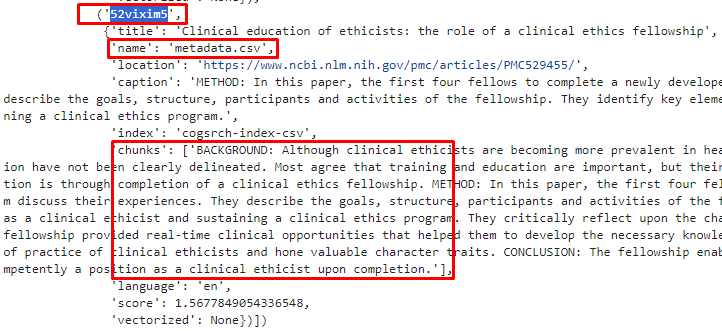

In [15]:
for OR in ordered_results:
    print(OR, ordered_results[OR]['name'], len(ordered_results[OR]['chunks']))

aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDcwMS8wNzAxMDgydjEucGRm0 0701082v1.pdf 5
aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDAxMS8wMDExMDMwdjEucGRm0 0011030v1.pdf 8
aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDAxMi8wMDEyMDE0djEucGRm0 0012014v1.pdf 9
aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDMxMC8wMzEwMDQydjEucGRm0 0310042v1.pdf 11
5ed5k9tq metadata.csv 1
vnmg0zid metadata.csv 1
aHR0cHM6Ly9ibG9ic3RvcmFnZW9xdWRlcnRlamZjcXcuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDAwMS8wMDAxMDA5djEucGRm0 0001009v1.pdf 11
u2g30x1j metadata.csv 1
5o38ihe0 metadata.csv 1
4mnaicki metadata.csv 1


## Please note that we haven't calculated any embeddings so far: we just split each  documents in chunks
So now we may start from this *ordered_results* "**ordered dictionary**" to fill the Vector Index of Azure Cognitive Search by converting chunk by chunk "on the fly" and write it into the *-vector* index.<br/>
Now we can fill up the vector-based index as users lookup documents using the text-based index. Although this approach requires two searches per user query (one on the text-based indexes and the other one on the vector-based indexes), it's simpler to implement and will be incrementatly faster as user use the system.<br/><br/>

**HOW IT WORKS**<br/>
For each document of *order_results", where each document includes the chunks array, it calculates the chunk embedding and then it inserts it -together with the chunk itself- into the next "-vector" index.<br/>
If -for testing reasons- we need to "reset" the field "vectorize=false" to avoid it skips the documents already flagged as *vectorized*, we may leverage the following snippet:
```
for key,value in ordered_results.items():
    print(value["vectorized"])
    upload_payload = {        
        "value": [
            {
                "id": key,
                "vectorized": False,
                "@search.action": "merge"
            },
        ]
    }    

    r = requests.post(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + value["index"]+ "/docs/index",
                     data=json.dumps(upload_payload), headers=headers, params=params)

ordered_results = get_search_results(QUESTION, indexes, k=10, reranke
```

This is a typical payload:
```
{
  "value": [
    {
      "id": "aHR0cHM6Ly9ibG9ic3RvcmFnZTV1Y3ptempiY3hkMnMuYmxvYi5jb3JlLndpbmRvd3MubmV0L2FyeGl2Y3MvMDAwMS8wMDAxMDE0djIucGRm0",
      "vectorized": "False",
      "@search.action": "merge"
    }
``` 

As a result, we get the nex values where each document is a ***single*** chunk with its embedding:<br/>
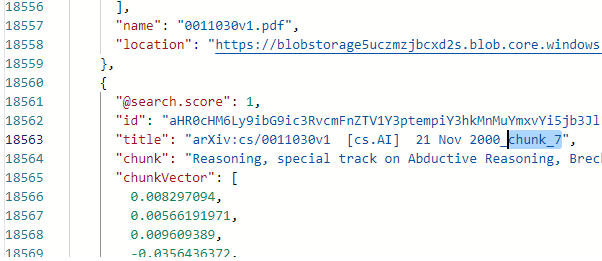

Now we can fill up the vector-based index as users lookup documents using the text-based index. This approach although it requires two searches per user query (one on the text-based indexes and the other one on the vector-based indexes), it is simpler to implement and will be incrementatly faster as user use the system.

In [16]:
embedder = OpenAIEmbeddings(deployment=os.environ['EMBEDDING_DEPLOYMENT'], chunk_size=1)

In [17]:
%%time
for key,value in ordered_results.items():
    if value["vectorized"] != True: # If the document has not been vectorized yet
        i = 0
        print("Vectorizing",len(value["chunks"]),"chunks from Document:",value["location"])
        for chunk in value["chunks"]: # Iterate over the document's text chunks
            try:
                upload_payload = {  # Insert the chunk and its vector in the vector-based index
                    "value": [
                        {
                            "id": key + "_" + str(i),
                            "title": f"{value['title']}_chunk_{str(i)}",
                            "chunk": chunk,
                            "chunkVector": embedder.embed_query(chunk if chunk!="" else "-------"),
                            "name": value["name"],
                            "location": value["location"],
                            "@search.action": "upload"
                        },
                    ]
                }

                r = requests.post(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + value["index"]+"-vector" + "/docs/index",
                                     data=json.dumps(upload_payload), headers=headers, params=params)
                
                if r.status_code != 200:
                    print(r.status_code)
                    print(r.text)
                else:
                    i = i + 1 # increment chunk number
                    
            except Exception as e:
                print("Exception:",e)
                print(chunk)
                continue
                    
        # Update document in text-based index and mark it as "vectorized"
        upload_payload = {
            "value": [
                {
                    "id": key,
                    "vectorized": True,
                    "@search.action": "merge"
                },
            ]
        }

        r = requests.post(os.environ['AZURE_SEARCH_ENDPOINT'] + "/indexes/" + value["index"]+ "/docs/index",
                         data=json.dumps(upload_payload), headers=headers, params=params)
                    

Vectorizing 5 chunks from Document: https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0701/0701082v1.pdf
Vectorizing 8 chunks from Document: https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0011/0011030v1.pdf
Vectorizing 9 chunks from Document: https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0012/0012014v1.pdf
Vectorizing 11 chunks from Document: https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0310/0310042v1.pdf
Vectorizing 1 chunks from Document: https://www.ncbi.nlm.nih.gov/pubmed/10403670/
Vectorizing 1 chunks from Document: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7103146/
Vectorizing 11 chunks from Document: https://blobstorageoqudertejfcqw.blob.core.windows.net/arxivcs/0001/0001009v1.pdf
Vectorizing 1 chunks from Document: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7131174/
Vectorizing 1 chunks from Document: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC280685/
Vectorizing 1 chunks from Document: https://www.ncbi.nlm.

**Note**: How the text-based and the vector-based indexes stay in sync?
For document changes, the problem is already taken care of, since Azure Engine will update the text-based index automatically if a file has a new version. This puts the vectorized field in None and the next time that the file is searched it will be vectorized again into the vector-based index.

However for deletion of files, the problem is half solved. Azure Search engine would delete the documents in the text-based index if the file is deleted on the source, however you will need to code a script that runs on a fixed schedule that looks for deleted ids in the text-based index and deletes the corresponding chunks in the vector-based index.

Now we search on the vector-based indexes and get the top k most similar chunks to our question:

In [18]:
vector_indexes = [index+"-vector" for index in indexes]

k = 10
similarity_k = 3
ordered_results = get_search_results(QUESTION, vector_indexes,
                                        k=k, # Number of results per vector index
                                        reranker_threshold=1,
                                        vector_search=True, 
                                        similarity_k=similarity_k,
                                        query_vector = embedder.embed_query(QUESTION)
                                        )
print("Number of results:",len(ordered_results))

Number of results: 3


In [19]:
ordered_results

OrderedDict([('5ed5k9tq_0',
              {'title': 'Quantification of recombinant core-like particles of bluetongue virus using immunosorbent electron microscopy._chunk_0',
               'name': 'metadata.csv',
               'location': 'https://www.ncbi.nlm.nih.gov/pubmed/10403670/',
               'caption': 'Immunosorbent electron microscopy was used to quantify recombinant baculovirus-generated bluetongue virus (BTV) core-like particles (CLP) in either purified preparations or lysates of recombinant baculovirus-infected cells. The capture antibody was an anti-BTV VP7 monoclonal antibody.',
               'index': 'cogsrch-index-csv-vector',
               'chunk': 'Immunosorbent electron microscopy was used to quantify recombinant baculovirus-generated bluetongue virus (BTV) core-like particles (CLP) in either purified preparations or lysates of recombinant baculovirus-infected cells. The capture antibody was an anti-BTV VP7 monoclonal antibody. The CLP concentration in purified

# How is the new *ordered_results* made?
Anche se è estratto dagli indici *-vector*, **ordered_results** non contiene embeddings (perché li abbiamo usati per prendere i risultati, ma ora non ci servono più), ma solo la coppia
- chunk_id
- dictionary(title, name, location, caption, index, **chunk**, score)

L'implementazione di get_search_results() in /common/utils.py è di circa 80 righe. Notiamo che:
- gli abbiamo passato *query_vector* già trasformata in embeddings,
- se vector_search=True (come in questo caso), allora i campi restituiti sono 5 (più score in automatico), altrimenti sono 7
- la risposta della funzione (ovvero il nuovo *ordered_content*) è totalmente costruita nella funzione
```
if vector_search:
    search_payload["vectors"]= [{"value": query_vector, "fields": "chunkVector","k": k}]
    search_payload["select"]= "id, title, chunk, name, location"
else:
    search_payload["select"]= "id, title, chunks, language, name, location, vectorized"
```

Nella prossima cella usiamo **ordered_results** di tipo **OrderedDict()** per costruire un **array di oggetti Document** dove ogni documento ha solo 2 chiavi, perché poi passeremo questo ordered_results ad un **qa_with_sources** che sottopone al Completion tutti i chunk:
- page_content, which contains the selected chunk
- metadata (with the \"source\" key only)

For vector search is not recommended to give more than k=5 chunks (of max 5000 characters each) to the LLM as context. Otherwise you can have issues later with the token limit trying to have a conversation with memory.

In [20]:
top_docs = []
for key,value in ordered_results.items():
    location = value["location"] if value["location"] is not None else ""
    top_docs.append(Document(page_content=value["chunk"], metadata={"source": location}))
        
print("Number of chunks:",len(top_docs))
print(f"top_docs: {top_docs}")

Number of chunks: 3
top_docs: [Document(page_content='Immunosorbent electron microscopy was used to quantify recombinant baculovirus-generated bluetongue virus (BTV) core-like particles (CLP) in either purified preparations or lysates of recombinant baculovirus-infected cells. The capture antibody was an anti-BTV VP7 monoclonal antibody. The CLP concentration in purified preparations was determined to be 6.6 x 10(15) particles/l. CLP concentration in lysates of recombinant baculovirus-infected cells was determined at various times post-infection and shown to reach a value of 3 x 10(15) particles/l of culture medium at 96 h post-infection. The results indicated that immunosorbent electron microscopy, aided by an improved particle counting method, is a simple, rapid and accurate technique for the quantification of virus and virus-like particles produced in large scale in vitro systems.', metadata={'source': 'https://www.ncbi.nlm.nih.gov/pubmed/10403670/'}), Document(page_content='In vitr

In [21]:
# Calculate number of tokens of our docs
if(len(top_docs)>0):
    tokens_limit = model_tokens_limit(MODEL) # this is a custom function we created in common/utils.py
    prompt_tokens = num_tokens_from_string(COMBINE_PROMPT_TEMPLATE) # this is a custom function we created in common/utils.py
    context_tokens = num_tokens_from_docs(top_docs) # this is a custom function we created in common/utils.py
    
    requested_tokens = prompt_tokens + context_tokens + COMPLETION_TOKENS
    
    chain_type = "map_reduce" if requested_tokens > 0.8 * tokens_limit else "stuff"  
    
    print("System prompt token count:",prompt_tokens)
    print("Max Completion Token count:", COMPLETION_TOKENS)
    print("Combined docs (context) token count:",context_tokens)
    print("--------")
    print("Requested token count:",requested_tokens)
    print("Token limit for", MODEL, ":", tokens_limit)
    print("Chain Type selected:", chain_type)
        
else:
    print("NO RESULTS FROM AZURE SEARCH")

System prompt token count: 1669
Max Completion Token count: 1000
Combined docs (context) token count: 803
--------
Requested token count: 3472
Token limit for gpt-35-turbo : 4096
Chain Type selected: map_reduce


Now we will use our Utility Chain from LangChain `qa_with_sources`

In [22]:
print(f"using {chain_type}...")

if chain_type == "stuff":
    chain = load_qa_with_sources_chain(llm, chain_type=chain_type, 
                                       prompt=COMBINE_PROMPT)
elif chain_type == "map_reduce":
    chain = load_qa_with_sources_chain(llm, chain_type=chain_type, 
                                       question_prompt=COMBINE_QUESTION_PROMPT,
                                       combine_prompt=COMBINE_PROMPT,
                                       return_intermediate_steps=True)

using map_reduce...


In [23]:
COMBINE_QUESTION_PROMPT

PromptTemplate(input_variables=['context', 'question', 'language'], template='Use the following portion of a long document to see if any of the text is relevant to answer the question. \nReturn any relevant text in {language}.\n{context}\nQuestion: {question}\nRelevant text, if any, in {language}:')

In [24]:
COMBINE_PROMPT

PromptTemplate(input_variables=['summaries', 'question', 'language'], template='\n\nThese are examples of how you must provide the answer:\n\n--> Beginning of examples\n\n=========\nQUESTION: Which state/country\'s law governs the interpretation of the contract?\n=========\nContent: This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in  relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an  injunction or other relief to protect its Intellectual Property Rights.\nSource: https://xxx.com/article1.pdf?s=casdfg&category=ab&sort=asc&page=1\n\nContent: No Waiver. Failure or delay in exercising any right or remedy under this Agreement shall not constitute a waiver of such (or any other)  right or remedy.\n\n11.7 Severability. The invalidity, illegality or unenforceability of any term (or part of a term) of this Agreement shall not affect the conti

In [25]:
%%time
# Try with other language as well
response = chain({"input_documents": top_docs, "question": QUESTION, "language": "English"})
response

CPU times: user 19.4 ms, sys: 0 ns, total: 19.4 ms
Wall time: 2.42 s


{'input_documents': [Document(page_content='Immunosorbent electron microscopy was used to quantify recombinant baculovirus-generated bluetongue virus (BTV) core-like particles (CLP) in either purified preparations or lysates of recombinant baculovirus-infected cells. The capture antibody was an anti-BTV VP7 monoclonal antibody. The CLP concentration in purified preparations was determined to be 6.6 x 10(15) particles/l. CLP concentration in lysates of recombinant baculovirus-infected cells was determined at various times post-infection and shown to reach a value of 3 x 10(15) particles/l of culture medium at 96 h post-infection. The results indicated that immunosorbent electron microscopy, aided by an improved particle counting method, is a simple, rapid and accurate technique for the quantification of virus and virus-like particles produced in large scale in vitro systems.', metadata={'source': 'https://www.ncbi.nlm.nih.gov/pubmed/10403670/'}),
  Document(page_content='In vitro assemb

In [26]:
display(Markdown(response['output_text']))

CLP stands for core-like particles<sup><a href="https://www.ncbi.nlm.nih.gov/pubmed/10403670/" target="_blank">[1]</a></sup><sup><a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7103146/" target="_blank">[2]</a></sup>.

**Please Note**: There are some instances where, despite the answer's high accuracy and quality, the references are not done according to the instructions provided in the COMBINE_PROMPT. This behavior is anticipated when dealing with GPT-3.5 models. We will provide a more detailed explanation of this phenomenon towards the conclusion of Notebook 5.

In [27]:
# Uncomment if you want to inspect the results from map_reduce chain type, each top similar chunk summary (k=4 by default)

if chain_type == "map_reduce":
    for step in response['intermediate_steps']:
        display(HTML("<b>Chunk Summary:</b> " + step))

# Summary
##### This answer is way better than taking just the result from Azure Cognitive Search. So the summary is:
- Utilizing Azure Cognitive Search, we conduct a multi-index text-based search that identifies the top documents from each index.
- Utilizing Azure Cognitive Search's vector search, we extract the most relevant chunks of information.
- Subsequently, Azure OpenAI utilizes these extracted chunks as context, comprehends the content, and employs it to deliver optimal answers.
- Best of two worlds!

# NEXT
In the next notebook, we are going to see how we can treat complex and large documents separately, also using Vector Search